王振华、祁雅萍
## 静态部分
1. 文本预处理(分词、停用词等)
2. Tf-Idf将文本向量化
3. kmeans初步聚类，每一个cluster用一个TSV来表示
4. 对每个TSV摘要
    - LexRank(或者其他)获得与该TSV中心最接近的Tweet
    - 为防止获得的摘要内容过于接近，采用以下办法
    - 按公式，获得尽可能接近TSV中心、又与之前得到的推特相似度尽可能小的Tweet，其中$\lambda$是可以调节的参数
    $$
      t = argmax_{t_i} [ \lambda \frac{n_{t_i}}{n_{max}} LR(t_i) - (1-\lambda)avg_{t_j \in S}Sim(t_i, t_j)  ]
    $$
    - 往复上述步骤，获得若干条高度概括，内容有所不同的Tweet

## 动态部分
1. Pyramidal Time Frame
2. 新的Tweet进来，寻找相似度最大cluster，比较“minimum bounding similarity”，
    - 若MBS<Sim(new tweet)，则将该tweet加入该cluster；
    - 若MBS>Sim(new tweet)，则新建一个cluster；
3. 我们认为话题的时间分布是符合正态的，已知tsv可计算时间均值和方差，故可以此估计话题时间线是否已到达正态曲线的末端
4. 当cluster的数量过多时，我们需要进行合并

5. **timeline : variations方差**
    
## 待解决
1. 词袋在开始时就已经确定，无法随时间变化而更新
2. 使用kmeans聚类时，没有考虑时间
    - 高永兵, 陈超, 熊振华,等. 基于个人微博特征的事件提取研究[J]. 计算机应用与软件, 2016, 33(7):47-51.
    - 先将tweet按时间分组，分别聚类，再逐渐合并
3. 只实现了静态部分，待效果达到要求后再考虑tweet stream 
4. 摘要只做到了extraction, 而不是abstraction. 需要将其进一步整合为3W1H的结构化数据
    - what : 发生了什么
    - who : 实体识别，命名体识别
    - when : 每个聚类前1%作为事件发生时间
    - how : 详细描述

## 其他
0. 当前品牌的地理分布不明显，暂时不考虑地理因素
0. 仅针对Tweet这类体裁，需要考虑url, hashtag, 发帖人之间的关系等
0. 暂时没有考虑发帖用户的比重(暂时令wi=1
0. 对命名实体加权，使结果尽量返回带有命名实体的内容(tf加权, idf不变)

## 其他2
0. 出发词检测是否有事件
0. 事件是否实现定义？


In [1]:
%load_ext autoreload
%autoreload 2
import jieba
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime 
from snownlp import normal
from matplotlib import pyplot as plt
import sklearn.cluster as skcluster
from datatype import *
from summary import *
from vectorizerIt import *
from filereader import *

In [2]:
users = readUsers('data/weibo_user.csv')
tweets = readTweets('data/user_posts.csv', noUrl=True, noTopic=True, noAtUser=True)

781
!! ['post_id', 'post_time', 'content', 'poster_id', 'poster_url', 'repost_num', 'comment_num', 'repost_post_id', 'inner_flag']
!! ['3.74487E+15', '', '', '', '', '', '', '', '']
!! ['3.66561E+15', '2014/1/11 17:26', '????????~!!!!!!!!?????????????????????~!!^^??????????????~^^', '2600208451', '', '', '', '', '']
11581


In [3]:
# 分词
corpusl_wsw = [jieba.lcut(t.content) for t in tweets]
corpusl = [normal.filter_stop(c) for c in corpusl_wsw]
corpus = [' '.join(c) for c in corpusl]

Building prefix dict from the default dictionary ...
2017-07-14 02:02:51,476 : DEBUG : Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
2017-07-14 02:02:58,386 : DEBUG : Dumping model to file cache /tmp/jieba.cache
Loading model cost 7.295 seconds.
2017-07-14 02:02:58,777 : DEBUG : Loading model cost 7.295 seconds.
Prefix dict has been built succesfully.
2017-07-14 02:02:58,789 : DEBUG : Prefix dict has been built succesfully.


In [4]:
# np.delete(vecit._transformer._dfidf, 0).shape
# vecit._transformer._dfidf.shape

In [5]:
# otfidf = TfIdf(corpus)
odfidf = DfIdf(corpus)
# ow2v = Word2Vec(corpusl, 100)
# od2v = Doc2Vec(corpusl, 100)
vecit = odfidf

In [6]:
'''
(tvi;tsi;wi;t)
where tvi is the textual vector, 
tsi is the posted timestamp 
and wi is the UserRank value of the tweet’s author.
'''
def generateTriples(tweets, o):
    triples = []
    for i, t in enumerate(tweets):
        tvi = o.vecs[i]
        tsi = t.post_time
        wi = 1
        triples.append(TweetVector(tvi, tsi, wi, t))
    return triples
triples = generateTriples(tweets, vecit)

In [7]:
# k-means cluster
n_clusters = 10
km = skcluster.KMeans(n_clusters=n_clusters, init='random', n_init=3, verbose=0)
# km = skcluster.MeanShift()
km.fit(vecit.vecs)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=10, n_init=3, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
'''
tweet cluster vector is defined as a tuple: (sum_v; wsum_v; ts1; ts2; n; ft_set)
'''
print(len(km.labels_), len(triples))
clusters = [[] for _ in range(n_clusters)]
for i in range(len(km.labels_)):
    clusters[km.labels_[i]].append(triples[i])
# for c in clusters:
#     print(len(c))
tsvs = []
for c in clusters:
    if len(c) < 20:
        continue
    tsvs.append(TSV(c, 50))
    

11581 11581


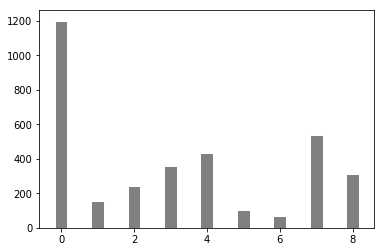

In [9]:
plt.bar(range(len(tsvs)),[tsv.n for tsv in tsvs],width = 0.35,facecolor = 'gray',edgecolor = 'white')
plt.show()

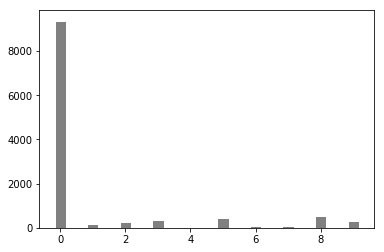

In [10]:
plt.bar(range(len(clusters)),[len(c) for c in clusters],width = 0.35,facecolor = 'gray',edgecolor = 'white')
plt.show()

In [11]:
# summary
for tsv in tsvs:
    pp.pprint(summaryLexRank(tsv, 3, threshold=0.1))

('网络ID就像另一个世界中的自己，而昵称就是自己的另一个名字！', '作为一个猫奴我很解恨', '十月怀胎出一个帅哥十年修炼才出一个才子')
('每个人都会有这样的感觉吧', '"我感觉我最近可能会有点作。恩', '看它那熊样！想吐的感觉！')
(   '孩子们都对探索之旅感兴趣呢，老家有奶牛带宝宝观摩一下哦//:奖品很给力嘛，今晚就让粑粑和倪儿一起玩起来！',
    '今晚带上老婆孩子五星旋转餐厅FB一把，看海景品美食，这里的鳗鱼寿司味道很棒，',
    '终于有希望了！被拐卖妇女儿童的买方也有罪了！这一切来之不易！我们的电影《亲爱的》一边在放映，另一面却每天收到各地刚丢失孩子的信息。我们还需要完整有效的防丢拐的预警系统！毕竟往好的方向发展了！替孩子们感谢一直在为此努力的人们！')
('手机也要支持，写的太好θ了！', '//:无水印手机壁纸!手机壁纸天天换~让你的手机拥有不一样的感觉。', '如果猫也会用手机直播的话......')
(   '"今天是11月9日，即“119”；明天是11月10日',
    '关于恒大足球训练基地11月份开放日的公告月份的基地开放日定于11月9日10:30-12:00',
    '11点56分，小米天猫旗舰店支付金额破10亿！！')
(   '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）',
    '来看看我拍的MV：“”，点此播放&gt;&gt;|美拍（通过录制）',
    '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）')
(   '的士司机给我讲述了昨天他目睹的一幕闹剧，男子让女人不要出差，女人不答应，男人就砍伤她，路人出手相救打了男人的脑袋，男人扭头追路人，追不上，就自己捅了自己一刀。。我一搜，还真到处报道了，真是没用这男人。当今社会男人的心理脆弱变态的比例绝对远超女人',
    '如果一个男人不打电话给你，因为他从来没有想过要打给你。如果一个男人对你好像毫不在乎，那么他真的完全不在意你。如果一个男人真爱你，怎么他都会来找你，如果他没来，说明——',
    '如果一个男人不打电话给你，因为他从来没有想过要打给你。如果一个男人对你好像毫不在乎，那么他真的完全不在意你。如果一个男人真爱你，怎么他都会来找你，如果他没来，说明——')
('哇！真的啊！真的啊！', '菇凉，你确定你

In [12]:
# summary
for tsv in tsvs:
#     weibos = [tv.t.content for tv in tsv.ft_set]
#     pp.pprint(summaryTextRank(weibos, 3))

#     pp.pprint(summaryLexRank(tsv, 3))
    pp.pprint(summaryTSVRank(tsv, 3, lbd=0.01, nmax=50))

['网络ID就像另一个世界中的自己，而昵称就是自己的另一个名字！', '十月怀胎出一个帅哥十年修炼才出一个才子', '作为一个猫奴我很解恨']
['每个人都会有这样的感觉吧', '嘻嘻，看《全能星战》有看演唱会的感觉。我喜欢吴克羣。', '拔了一颗智齿之后感觉体重轻了很多，萌萌哒']
[   '孩子们都对探索之旅感兴趣呢，老家有奶牛带宝宝观摩一下哦//:奖品很给力嘛，今晚就让粑粑和倪儿一起玩起来！',
    '今晚带上老婆孩子五星旋转餐厅FB一把，看海景品美食，这里的鳗鱼寿司味道很棒，',
    '终于有希望了！被拐卖妇女儿童的买方也有罪了！这一切来之不易！我们的电影《亲爱的》一边在放映，另一面却每天收到各地刚丢失孩子的信息。我们还需要完整有效的防丢拐的预警系统！毕竟往好的方向发展了！替孩子们感谢一直在为此努力的人们！']
[   '手机也要支持，写的太好θ了！',
    '我觉得习大大一定是开启了360手机卫士的骚扰拦截功能！',
    '【dospy第一资讯】带有会动的眼睛LG发布新机AKA：上个月LG曾推出了一款名为AKA的概念手机，它最大的亮点就是装上自带的四种保护壳之后手机待机时屏幕上会显示出不同的动态眼睛，十分活泼可爱。根据国外媒体的消息，LG今天在韩国正式发布了这款手机，不过售价暂时还不清楚。']
[   '"今天是11月9日，即“119”；明天是11月10日',
    '关于恒大足球训练基地11月份开放日的公告月份的基地开放日定于11月9日10:30-12:00',
    '11点56分，小米天猫旗舰店支付金额破10亿！！']
[   '来看看我拍的MV，点此播放&gt;&gt;|美拍（通过录制）',
    '快来参加，把最爱的耳机放到你的碗里去！&gt;&gt;&gt;',
    '来看看我拍的MV：“这一个有你分享的生日，三十年来头一回”，点此播放&gt;&gt;|美拍（通过录制）']
[   '的士司机给我讲述了昨天他目睹的一幕闹剧，男子让女人不要出差，女人不答应，男人就砍伤她，路人出手相救打了男人的脑袋，男人扭头追路人，追不上，就自己捅了自己一刀。。我一搜，还真到处报道了，真是没用这男人。当今社会男人的心理脆弱变态的比例绝对远超女人',
    '如果一个男人不打电话给你，因为他从来没有想过要打给你。如果一个男人对你好像毫不在

In [13]:
# def fun():
#         summaryLexRank(tsv, 3)
# %prun -s tottime fun()

<datatype.TSV object at 0x7f1aef43a6a0> 0.640593903539
0.230693312314


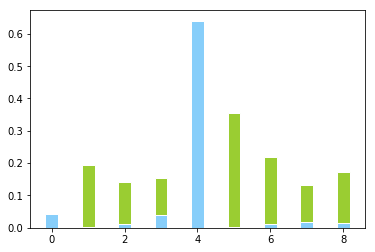

In [14]:
post = '"今天是11月9日，即“119”；明天是11月10日'
post = ' '.join(normal.filter_stop(jieba.lcut(post)))
post_vec = vecit.vectorizer(post)
# print(post_vec.data)
t = Tweet('2015/10/11 14:33', 
          post, None, None, 1, 1)
tv = TweetVector(post_vec,datetime(2015,10,11,14,33).timestamp(),1,t)

def maxSimInTSVs(tv, tsvs):
    maxSim_tsv = tsvs[0]
    maxSim = maxSim_tsv.maxSim(tv)
    sims = []
    for tsv in tsvs:
        sim = tsv.maxSim(tv)
        sims.append(sim)
        if sim > maxSim:
            maxSim_tsv = tsv
            maxSim = sim
    return maxSim_tsv, maxSim, sims

max_sim_tsv, max_sim, sims = maxSimInTSVs(tv, tsvs)
print(max_sim_tsv, max_sim)
print(max_sim_tsv.mbs(1))

plt.bar(range(len(sims)),[tsv.mbs(0.5) for tsv in tsvs],width = 0.35,facecolor = 'yellowgreen',edgecolor = 'white')
plt.bar(range(len(sims)),sims,width = 0.35,facecolor = 'lightskyblue',edgecolor = 'white')
plt.show()

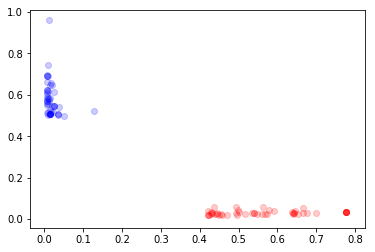

In [15]:
def cosine_similarity(v1, v2):
    if sparse.issparse(v1):
        return (sparse.csr_matrix.dot(v1, v2.transpose()) / 
                (normFor1DSparseMatrixNonZero(v1) * normFor1DSparseMatrixNonZero(v2)))[0,0]
    return (np.dot(v1, v2)) / (normFor1DSparseMatrixNonZero(v1) * normFor1DSparseMatrixNonZero(v2))
sims_8_to_8 = [cosine_similarity(tsvs[-2].cv, tv.tvi) for tv in tsvs[-2].ft_set]
sims_8_to_9 = [cosine_similarity(tsvs[-1].cv, tv.tvi) for tv in tsvs[-2].ft_set]
sims_9_to_8 = [cosine_similarity(tsvs[-2].cv, tv.tvi) for tv in tsvs[-1].ft_set]
sims_9_to_9 = [cosine_similarity(tsvs[-1].cv, tv.tvi) for tv in tsvs[-1].ft_set]
plt.scatter(sims_8_to_8,sims_8_to_9,c='red',alpha=0.2,marker='o')
plt.scatter(sims_9_to_8,sims_9_to_9,c='blue',alpha=0.2,marker='o')
plt.show()

In [41]:
def fun(i, text):
    return [w for w in jieba.cut(text) for _ in range(int(i))]

In [28]:
%prun fun(2e6, '有多少没睡的夜猫子呢？进来点个赞！')

         2000004 function calls in 6.601 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.224    5.224    6.601    6.601 <ipython-input-25-0920ff5ec6bc>:1(fun)
  2000000    1.376    0.000    1.376    0.000 __init__.py:272(cut)
        1    0.000    0.000    6.601    6.601 {built-in method builtins.exec}
        1    0.000    0.000    6.601    6.601 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [ ]:
%prun fun(1e6, '有多少没睡的夜猫子呢？进来点个赞！')

In [51]:
lt = ''.join(['有多少没睡的夜猫子呢？进来点个赞！']*int(1e5))
%prun fun(10, lt)

         30200009 function calls in 143.412 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   200000   22.908    0.000   46.895    0.000 __init__.py:37(viterbi)
   200000   14.234    0.000   16.179    0.000 __init__.py:178(get_DAG)
  3600000   13.681    0.000   20.403    0.000 __init__.py:175(<genexpr>)
  3300000   12.601    0.000   34.689    0.000 {built-in method builtins.max}
  7900000   11.620    0.000   11.620    0.000 {method 'get' of 'dict' objects}
   200000    9.775    0.000   38.477    0.000 __init__.py:170(calc)
  1100000    9.060    0.000  126.687    0.000 __init__.py:232(__cut_DAG)
  1600000    8.845    0.000   12.025    0.000 __init__.py:49(<listcomp>)
        1    8.773    8.773  143.212  143.212 <ipython-input-41-0ad46a83e791>:2(<listcomp>)
   600000    4.901    0.000   51.946    0.000 __init__.py:59(__cut)
  1100001    4.729    0.000  134.439    0.000 __init__.py:272(cut)
   600000    4.300    0.000   61.9